In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy.stats as sstats 

# A Typical Linear Problem

Consider the linear problem

$$
    q = Ax, \ x\in\mathbb{R}^n, \ q\in \mathbb{R}^p, \ A\in\mathbb{R}^{p\times n}
$$

where we assume that $p\leq n$ and $A$ is rank $p$. 

# Statistical Bayesian connection to Tikhonov regularization

Assuming we observe datum $\tilde{q}$ and that we are using a Gaussian prior ($N(\bar{x},C_x)$) and Gaussian noise model ($N(0,C_q)$), the statistical Bayesian posterior is given by

$$
    \pi^{\text{post}} \propto \exp\left(-\frac{1}{2}\left( 
    \underbrace{\left|\left|C_q^{-1/2}(q-\tilde{q})\right|\right|_2^2}_{\text{Data mismatch}} + 
    \underbrace{\left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2}_{\text{Tikhonov regularization}}
    \right)\right)
$$

where we have made explicit the connection of the MAP (maximum a posteriori) point of the posterior density with the Tikhnoov regularized solution to a deterministic optimization problem.

See https://en.wikipedia.org/wiki/Tikhonov_regularization for more information.

## Take-aways


* The model defines the data mismatch and the prior defines the regularization. 


* The regularization impacts ***all directions*** of the posterior since we effectively balance the data mismatch with our prior beliefs. This implies that the "solution" defined by a MAP point is not necessarily a point that produces the observed datum.

# Consistent Bayesian and *unregularization*

The statistical Bayesian posterior is given by the prior times the likelihood function divided by a normalizing constant.
However, the consistent Bayesian posterior is given by the observed density times the prior density divided by the push-forward of the prior density.
In this problem, with the same assumptions as above, the push-forward is Gaussian with covariance given by $C_A=AC_xA^\top$ and mean given by $\bar{q}=A\bar{x}$. 
Thus, the consistent Bayesian posterior is given by

$$
    \pi^{\text{post}} \sim \exp\left(-\frac{1}{2}\left( 
    \underbrace{\left|\left|C_q^{-1/2}(q-\tilde{q})\right|\right|_2^2}_{\text{Data mismatch}} 
    + 
    \underbrace{\left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2}_{\text{Tikhonov regularization}}
    - 
    \underbrace{\left|\left|C_A^{-1/2}(q-\bar{q})\right|\right|_2^2}_{\text{unregularization}}
    \right)\right)
$$

where we have categorized the effect of dividing by the push-forward as a source of ***unregularization*** in the MAP point.
To see this even more clearly, observe that we can collect and rewrite the regularization terms as

$$
    \left|\left|C_x^{-1/2}(x-\bar{x})\right|\right|_2^2 - \left|\left|C_A^{-1/2}(q-\bar{q})\right|\right|_2^2 = (x-\bar{x})^\top\underbrace{\left(C_x^{-1}-A^\top(AC_xA^\top)^{-1} A \right)}_{R}(x-\bar{x})
$$

where $R$ is the ***regularization matrix***.

## Take-aways


* If $A$ is rank $n$ and invertible, then $R=0$. In other words, regularization is ***turned off*** if there is a unique solution.

# Example

Consider the linear problem where
$$
    A = [2 \ -1],\ \bar{x}=\left[\begin{array}[c]  00.2 \\ 0.2 \end{array}\right],   \\
    \ C_x = \text{diag}(0.5, 0.25),  \\
    \ \tilde{q} = [0.1], \ C_q = [0.25].
$$

## Things to play with

* Try changing the `x_prior` in the code to something other than $[0.2 \ 0.2]^\top$ to make the prior guess either better or worse. What happens?

* Try playing with the `C_x` covariance to give the prior guess either more confidence (reduce the components) or less confidence (increase the components). What happens?

In [2]:
# Setup example and prior guess, prior prediction, and actual datum

A = np.array([[2, -1]]) #map
x_prior = np.array([[0.2, 0.2]]).transpose() #prior guess of mean
q_obs = np.array([0.1]) #actual datum
q_prior = np.dot(A,x_prior) #predicted datum using prior
print('Prior Mean (x1,x2) =', *x_prior, 'maps to q =', *q_prior[0])

Prior Mean (x1,x2) = [0.2] [0.2] maps to q = 0.2


In [3]:
# Setup all the covariances

C_x = np.diag([0.5,0.25]) #prior covariance
C_q = np.diag([0.25]) #data covariance
C_A = np.dot(np.dot(A,C_x),A.transpose()) #the "covariance of the map"

In [4]:
# define the various weighted sum squares of errors (WSSE) given by 
# the data misfit, Tikhonov regularization, and unregularization terms. 

... # defining functions that depend on variables in the global namespace makes for bugs =/
def data_misfit(x):
    C_q_inv = np.linalg.inv(C_q)
    q = np.dot(A,x)
    WSSE = np.vdot(np.dot(C_q_inv,q-q_obs),q-q_obs) #weighted sum-squared error
    return WSSE
    
def Tikhonov_reg(x):
    C_x_inv = np.linalg.inv(C_x)
    WSSE = np.vdot(np.dot(C_x_inv,x-x_prior),x-x_prior) #weighted sum-squared error
    return WSSE

def unregularize(x):
    C_A_inv = np.linalg.inv(C_A)
    q = np.dot(A,x)
    WSSE = np.vdot(np.dot(C_A_inv,q-q_prior),q-q_prior) #weighted sum-squared error
    return WSSE

In [5]:
# Discretize a portion of the input space R^2

n = 101
x1 = np.linspace(-0.5,0.5,n)
x2 = x1
x1,x2 = np.meshgrid(x1,x2)

In [6]:
# Compute all the WSSE terms

WSSE = np.zeros((n,n))
TSSE = np.zeros((n,n))
USSE = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        WSSE[j,i] = data_misfit(np.array([[x1[j,i],x2[j,i]]]).transpose())
        TSSE[j,i] = Tikhonov_reg(np.array([[x1[j,i],x2[j,i]]]).transpose())
        USSE[j,i] = unregularize(np.array([[x1[j,i],x2[j,i]]]).transpose())

<IPython.core.display.Javascript object>


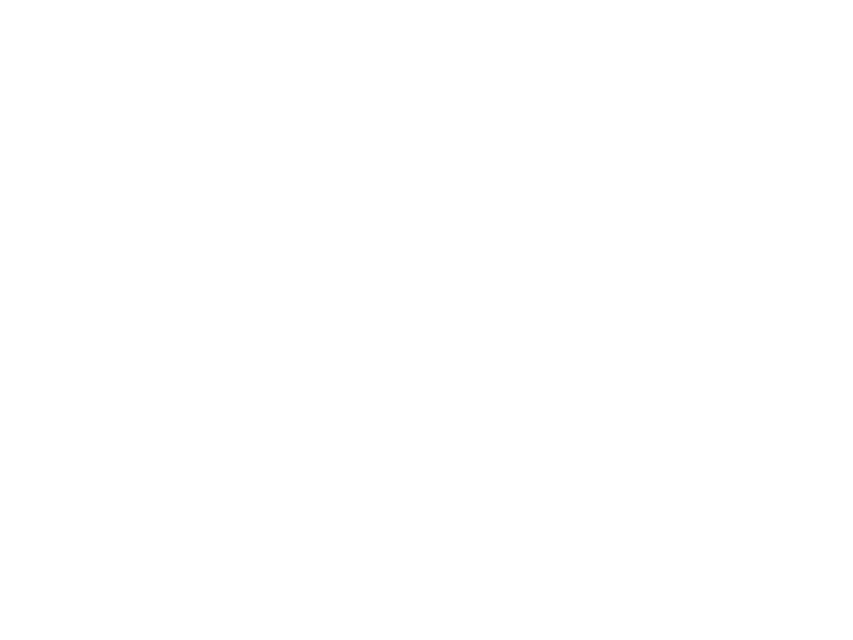

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

<IPython.core.display.Javascript object>


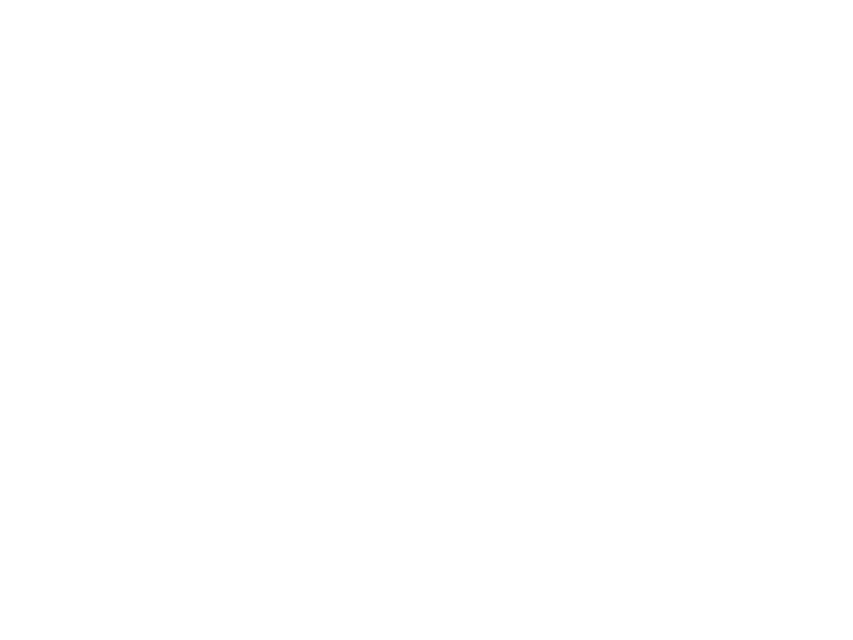

In [8]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, TSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

<IPython.core.display.Javascript object>


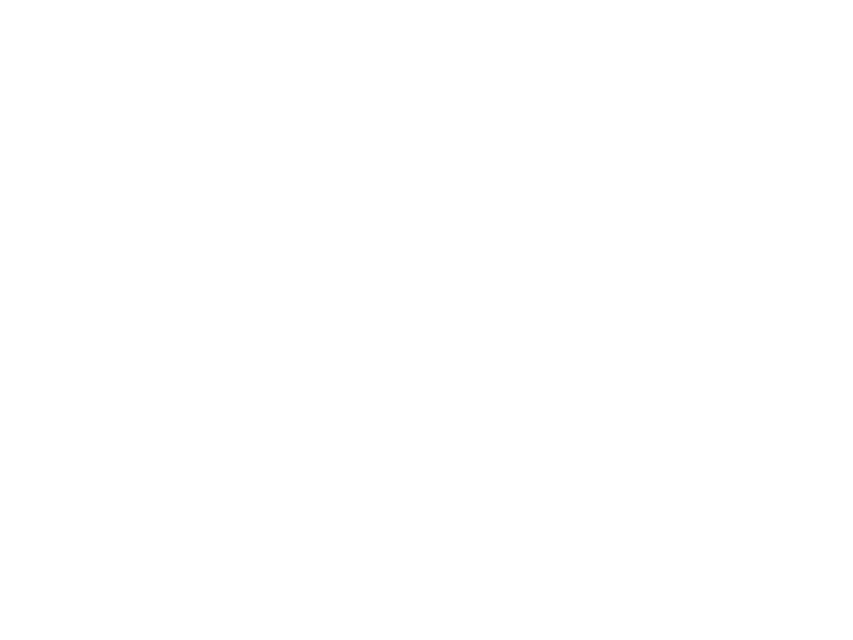

In [9]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, TSSE-USSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')

plt.show()

<IPython.core.display.Javascript object>


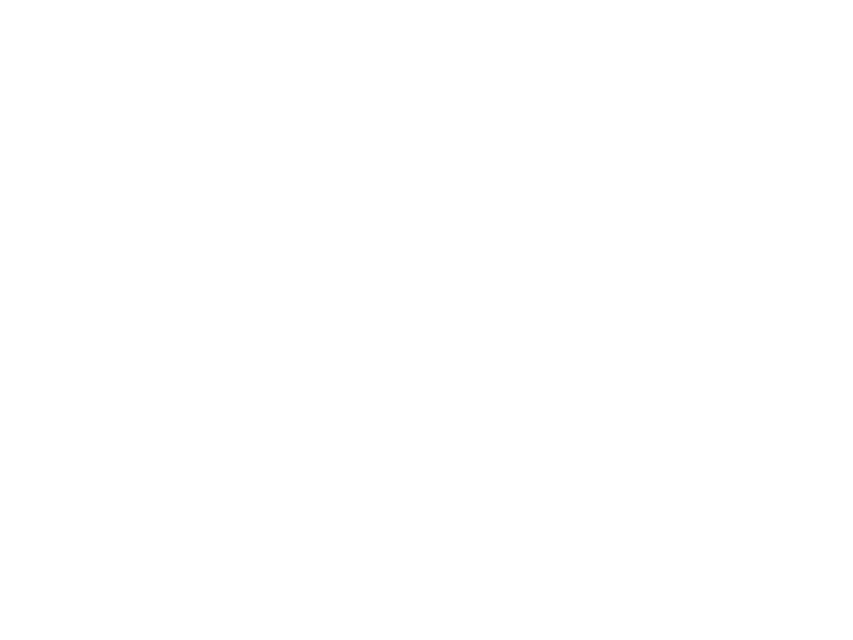

In [10]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE + TSSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

<IPython.core.display.Javascript object>


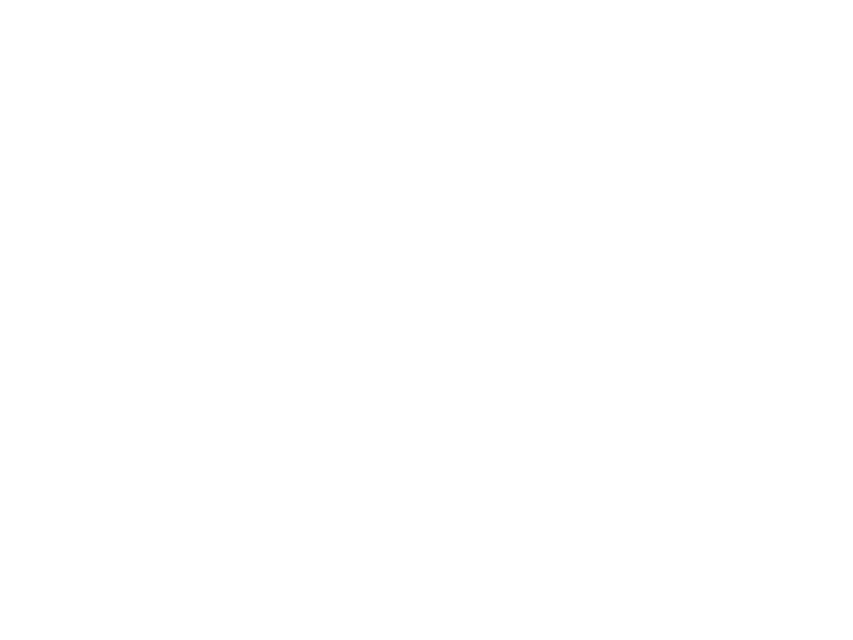

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x1, x2, WSSE + TSSE - USSE, cmap=cm.hot,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
plt.show()

In [12]:
x_reg_ind = np.argmin(WSSE+TSSE)
print('MAP Tikonov point')
print([x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]])

MAP Tikonov point
[0.16000000000000003, 0.20999999999999996]


In [13]:
x_unreg_ind = np.argmin(WSSE+TSSE-USSE)
print('MAP CB point')
print([x1.flatten()[x_unreg_ind],x2.flatten()[x_unreg_ind]])

MAP CB point
[0.16000000000000003, 0.21999999999999997]


In [14]:
print('Absolute error in prediction through Tikonov: ', 
      np.abs(0.1 - np.dot(A,[x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]])[0]))


Absolute error in prediction through Tikonov:  0.010000000000000092


In [15]:
print('Absolute error in prediction through CB: ', 
      np.abs(0.1 - np.dot(A,[x1.flatten()[x_unreg_ind],x2.flatten()[x_unreg_ind]])[0]))


Absolute error in prediction through CB:  8.326672684688674e-17


In [16]:
[x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]]

[0.16000000000000003, 0.20999999999999996]

In [17]:
% matplotlib inline

In [18]:
def solve(n=101, data_cov_const=0.25, prior_x1=0.2, prior_x2=0.2, sigma_x1=0.5, sigma_x2=0.5):
    # Discretize a portion of the input space R^2
    # copied troy's code into here. 
    # Setup example and prior guess, prior prediction, and actual datum

    A = np.array([[2, -1]]) #map
    x_prior = np.array([prior_x1, prior_x2]).reshape(-1,1) #prior guess of mean
    
    def data_misfit(x):
        C_q_inv = np.linalg.inv(C_q)
        q = np.dot(A,x)
        WSSE = np.vdot(np.dot(C_q_inv,q-q_obs),q-q_obs) #weighted sum-squared error
        return WSSE
    
    def Tikhonov_reg(x):
        C_x_inv = np.linalg.inv(C_x)
        WSSE = np.vdot(np.dot(C_x_inv,x-x_prior),x-x_prior) #weighted sum-squared error
        return WSSE

    def unregularize(x):
        C_A_inv = np.linalg.inv(C_A)
        q = np.dot(A,x)
        WSSE = np.vdot(np.dot(C_A_inv,q-q_prior),q-q_prior) #weighted sum-squared error
        return WSSE

    q_obs = np.array([0.1]) #actual datum # leave fixed.
    q_prior = np.dot(A,x_prior) #predicted datum using prior
    print('Prior Mean (x1,x2) =', *x_prior, 'maps to q =', *q_prior[0])
    # Setup all the covariances
    prior_cov = [sigma_x1, sigma_x2]
    C_x = np.diag(prior_cov) #prior covariance
    C_q = np.diag([data_cov_const]) #data covariance
    C_A = np.dot(np.dot(A,C_x),A.transpose()) #the "covariance of the map"
    
    x1 = np.linspace(-0.5, 0.5,n)
    x2 = x1
    x1,x2 = np.meshgrid(x1,x2)
    # Compute all the WSSE terms

    WSSE = np.zeros((n,n))
    TSSE = np.zeros((n,n))
    USSE = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            WSSE[j,i] = data_misfit(np.array([[x1[j,i],x2[j,i]]]).transpose())
            TSSE[j,i] = Tikhonov_reg(np.array([[x1[j,i],x2[j,i]]]).transpose())
            USSE[j,i] = unregularize(np.array([[x1[j,i],x2[j,i]]]).transpose())

    x_reg_ind = np.argmin(WSSE+TSSE)
    x_unreg_ind = np.argmin(WSSE+TSSE-USSE)

    
    print('Absolute error in prediction through Tikonov: ', 
      np.abs(0.1 - np.dot(A,[x1.flatten()[x_reg_ind],x2.flatten()[x_reg_ind]])[0]))

    print('Absolute error in prediction through CB: ', 
      np.abs(0.1 - np.dot(A,[x1.flatten()[x_unreg_ind],x2.flatten()[x_unreg_ind]])[0]))

    
    f, axarr = plt.subplots(2, 3, figsize=[20,20])
    i, j = 0,0
    ax = axarr[i,j]
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('Prior')
    Z = sstats.multivariate_normal.pdf(np.concatenate([x1.reshape(-1,1), x2.reshape(-1,1)], axis=1), mean=x_prior.flatten(), cov=np.diag(prior_cov))
    ax.pcolormesh(x1, x2, Z.reshape(n,n), cmap=cm.hot, linewidth=0, antialiased=False)
    ax.scatter([x_prior[0]], [x_prior[1]], s=250,facecolor='red')
    Mv = ['WSSE', 'TSSE']
    for M in [WSSE, TSSE]:
        ax = axarr[i,j+1]
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_title(Mv[j])
        ax.pcolormesh(x1, x2, M, cmap=cm.hot, linewidth=0, antialiased=False)
        
        j +=1
        
    i, j = 1, 0
    Mv = ['WSSE + TSSE - USSE', 'TSSE - USSE', 'WSSE + TSSE', ]
    for M in [WSSE + TSSE - USSE, TSSE-USSE, WSSE + TSSE]:
        
        ax = axarr[i,j]
        ax.pcolormesh(x1, x2, M, cmap=cm.hot, linewidth=0, antialiased=False)
        if j == 0:
            ax.scatter([x1.flatten()[x_unreg_ind]], [x2.flatten()[x_unreg_ind]], s=250,facecolor='blue')
            ax.scatter([x_prior[0]], [x_prior[1]], s=250,facecolor='red')
        if j == 2:
            ax.scatter([x1.flatten()[x_reg_ind]], [x2.flatten()[x_reg_ind]], s=250,facecolor='blue')
            ax.scatter([x_prior[0]], [x_prior[1]], s=250,facecolor='red')
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.set_title(Mv[j])
        
        j +=1
        
    plt.show()
    


Prior Mean (x1,x2) = [0.2] [0.2] maps to q = 0.2
Absolute error in prediction through Tikonov:  0.010000000000000092
Absolute error in prediction through CB:  8.326672684688674e-17


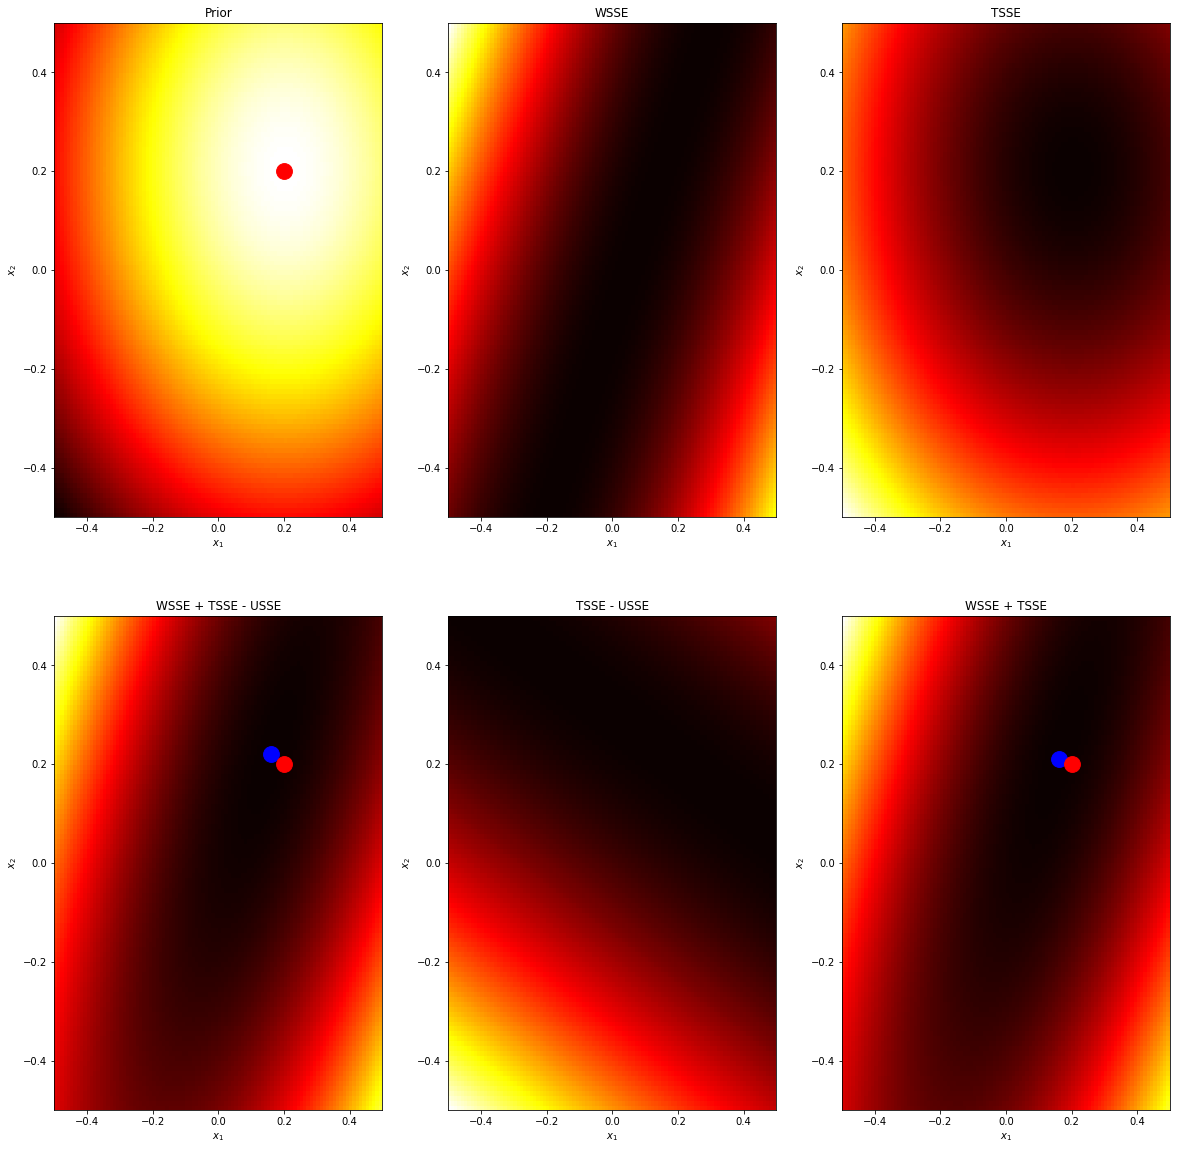

In [19]:
solve()

In [20]:
import ipywidgets
from  ipywidgets import interact

In [23]:
interact(solve, n = ipywidgets.fixed(101),
                   data_cov_const=ipywidgets.FloatSlider(value=0.05, min=0.001, max=2, step=0.001, continuous_update=False),
                   sigma_x1=ipywidgets.FloatSlider(value=0.5, min=0.025, max=2.5, step=0.025, continuous_update=False), 
                   sigma_x2=ipywidgets.FloatSlider(value=0.25, min=0.025, max=2.5, step=0.025,  continuous_update=False), 
                   prior_x1=ipywidgets.FloatSlider(value=0.2, min=-0.5, max=0.5, continuous_update=False), 
                   prior_x2=ipywidgets.FloatSlider(value=0.2, min=-0.5, max=0.5, continuous_update=False)
                  )


interactive(children=(FloatSlider(value=0.05, continuous_update=False, description='data_cov_const', max=2.0, min=0.001, step=0.001), FloatSlider(value=0.2, continuous_update=False, description='prior_x1', max=0.5, min=-0.5), FloatSlider(value=0.2, continuous_update=False, description='prior_x2', max=0.5, min=-0.5), FloatSlider(value=0.5, continuous_update=False, description='sigma_x1', max=2.5, min=0.025, step=0.025), FloatSlider(value=0.25, continuous_update=False, description='sigma_x2', max=2.5, min=0.025, step=0.025), Output()), _dom_classes=('widget-interact',))

<function __main__.solve>

# Observations


- when the prior approaches a uniform (sigma large relative to the bounds on the space under consideration), the two techniques produce the same answer.
- even a confident prior that is correct can lead to errors in the answer using Tikonov without un-regularization
- more confidence in your data does lead to more accuracy with plain Tikonov, and after a certain amount of uncertainty in the datum, the prior is essentially informing us completely, so we converge towards some error due to the prior having some small variance and the coarseness of our mesh
- if the prior and data are both uniformative, Tikonov gives a better approximation of the datum than if your prior was a tight gaussian distribution centered at the true data value.

- important to note is that the solution (estimate of the data) given by the Consisteny Bayesian Formulation is not subject to these same sensitivities. It remains accurate, even tolerating very uncertain priors and data. 